## Imports


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sn

In [2]:
path = "/content/drive/MyDrive/Thesis/Datasets/Turbofan_Dataset/final_datasets_normalized/"

In [3]:
# Load data and drop irrelevant columns

df_train = pd.read_csv(path + "TRAINING_SET_FULL.csv")
df_test = pd.read_csv(path + "TEST_SET_FULL.csv")

drop_cols = ["cycle","setting3","s1","s5","s10","s16","s18","s19","RUL"]
corr_cols = ["s11","s4","s15","s17","s2","s3","s8","s13","s9","s14","s12","s7","s20"]
feature_cols = ['cycle_norm', 'setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
prediction_col = 'fail_30'

train_set = df_train.drop(drop_cols, axis=1)
test_set = df_test.drop(drop_cols, axis=1)

## Generate Sequences

In [4]:
# Move cycle_norm column first for convenience

# column_to_move = train_set.pop("cycle_norm")
# train_set.insert(0, "cycle_norm", column_to_move)

# column_to_move = test_set.pop("cycle_norm")
# test_set.insert(0, "cycle_norm", column_to_move)

In [5]:
# Receives single engine dataframe, window size and features -> sequences of length==window_size
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [6]:
# gen = gen_train_data(train_set[train_set['id']==1], sequence_length=4, columns=feature_cols)
# engines = list(gen)

In [7]:
# Generates sequences for multiple engines
def gen_data_wrapper(df, sequence_length, columns, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
        
    data_gen = (list(gen_train_data(df[df['id']==id], sequence_length, columns))
               for id in ids)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [8]:
data_array = gen_data_wrapper(train_set, sequence_length=4, columns=feature_cols)
data_array.shape

(20331, 4, 18)

In [9]:
# Functions to generate sequences for the labals
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
        
    label_gen = [gen_labels(df[df['id']==id], sequence_length, label) 
                for id in ids]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [10]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]
def gen_test_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
    
    label_gen = [gen_labels(df[df['id']==id], sequence_length, label) 
                for id in ids]
    # keep only last window
    if sequence_length > 31:
      print("Too big window")
    else:
      last_labels = [label[-1] for label in label_gen] 
      



    last_labels = np.concatenate(last_labels).astype(np.float32)
    # return label_array
    return last_labels


In [11]:
sequence_length = 20

gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)


for train_unit, val_unit in gss.split(train_set['id'].unique(), groups=train_set['id'].unique()):
    train_unit = train_set['id'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = train_set['id'].unique()[val_unit]

    train_split_array = gen_data_wrapper(train_set, sequence_length, feature_cols, train_unit)
    train_split_label = gen_label_wrapper(train_set, sequence_length, ['fail_30'], train_unit)
    
    val_split_array = gen_data_wrapper(train_set, sequence_length, feature_cols, val_unit)
    val_split_label = gen_label_wrapper(train_set, sequence_length, ['fail_30'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(train_set, sequence_length, feature_cols)
label_array = gen_label_wrapper(train_set, sequence_length, ['fail_30'])

test_array = gen_data_wrapper(test_set, sequence_length, feature_cols)
test_label_array = gen_label_wrapper(test_set, sequence_length, ['fail_30'])

# test_gen = (list(gen_test_data(test_set[test_set['id']==id], sequence_length, feature_cols, -99.))
#            for id in test_set['id'].unique())
# test_array = np.concatenate(list(test_gen)).astype(np.float32)

# test_label_array = gen_test_label_wrapper(test_set, sequence_length, ['fail_30'])


In [12]:
train_array.shape

(18731, 20, 18)

In [13]:
test_label_array.shape

(11196, 1)

## Define model

In [14]:
# Defining LSTM model

model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='mean_squared_error', optimizer='adam')
# model.save_weights('simple_lstm_weights.h5')

In [15]:
(sequence_length, train_array.shape[2])

(20, 18)

## Train

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='binary_accuracy')  # the model is recompiled to reset the optimizer
# model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=25,
                   batch_size=64)

Epoch 1/25
236/236 [==============================] - 20s 48ms/step - loss: 0.1987 - binary_accuracy: 0.9191 - val_loss: 0.1067 - val_binary_accuracy: 0.9610
Epoch 2/25
236/236 [==============================] - 5s 20ms/step - loss: 0.1040 - binary_accuracy: 0.9576 - val_loss: 0.0955 - val_binary_accuracy: 0.9569
Epoch 3/25
236/236 [==============================] - 3s 15ms/step - loss: 0.1130 - binary_accuracy: 0.9545 - val_loss: 0.0911 - val_binary_accuracy: 0.9610
Epoch 4/25
236/236 [==============================] - 4s 15ms/step - loss: 0.0860 - binary_accuracy: 0.9653 - val_loss: 0.1110 - val_binary_accuracy: 0.9566
Epoch 5/25
236/236 [==============================] - 4s 15ms/step - loss: 0.1161 - binary_accuracy: 0.9534 - val_loss: 0.0862 - val_binary_accuracy: 0.9686
Epoch 6/25
236/236 [==============================] - 4s 15ms/step - loss: 0.0817 - binary_accuracy: 0.9658 - val_loss: 0.0784 - val_binary_accuracy: 0.9642
Epoch 7/25
236/236 [==============================] - 3s 

# Evaluation


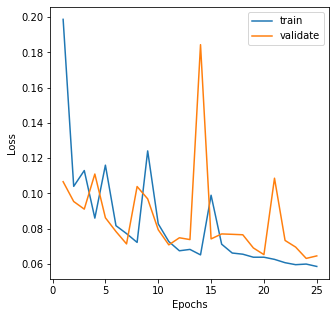

In [17]:
def plot_loss(fit_history):
    plt.figure(figsize=(5,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

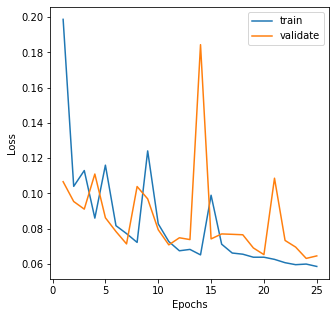

In [18]:
def plot_loss(fit_history):
    plt.figure(figsize=(5,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

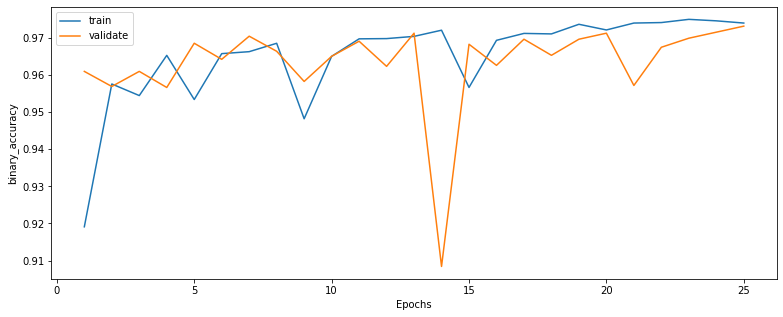

In [19]:
def plot_binary_accuracy(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['binary_accuracy'])+1), fit_history.history['binary_accuracy'], label='train')
    plt.plot(range(1, len(fit_history.history['val_binary_accuracy'])+1), fit_history.history['val_binary_accuracy'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('binary_accuracy')
    plt.legend()
    plt.show()

plot_binary_accuracy(history)

In [20]:
target_names = ['healthy', 'worn_out']

In [21]:
# Initial
# Train Score
y_hat_train = model.predict(train_array)
y_hat_int_train = y_hat_train.reshape(y_hat_train.shape[0]).round().astype(int)
label_array = label_array.reshape(label_array.shape[0]).astype(int)

print(classification_report(y_hat_int_train, label_array, target_names=target_names))

              precision    recall  f1-score   support

     healthy       0.99      0.99      0.99     15628
    worn_out       0.93      0.93      0.93      3103

    accuracy                           0.98     18731
   macro avg       0.96      0.96      0.96     18731
weighted avg       0.98      0.98      0.98     18731



In [22]:
# Initial
# Test set score

y_hat_test = model.predict(test_array)
y_hat_int_test = y_hat_test.reshape(y_hat_test.shape[0]).round().astype(int)
test_label_int = test_label_array.astype(int)

print(classification_report(y_hat_int_test, test_label_int, target_names=target_names))

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00     10854
    worn_out       0.87      0.84      0.85       342

    accuracy                           0.99     11196
   macro avg       0.93      0.92      0.93     11196
weighted avg       0.99      0.99      0.99     11196



In [23]:
# na testarw me ola ta test cycles

In [24]:
mtx = confusion_matrix(test_label_int, y_hat_int_test)
mtx_norm = confusion_matrix(test_label_int, y_hat_int_test, normalize='true')

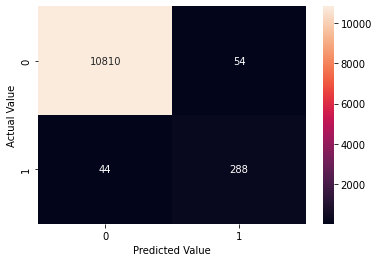

In [25]:
hm = sn.heatmap(mtx, annot=True, fmt='g')
hm.set(xlabel='Predicted Value', ylabel='Actual Value')
hm

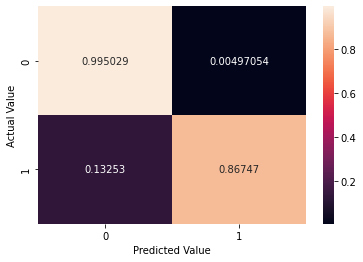

In [26]:
hm_norm = sn.heatmap(mtx_norm, annot=True, fmt='g')
hm_norm.set(xlabel='Predicted Value', ylabel='Actual Value')
hm_norm